In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
online_retail = fetch_ucirepo(id=352) 
  
# data (as pandas dataframes) 
df = online_retail.data.original
# metadata 
print(online_retail.metadata) 
  
# variable information 
print(online_retail.variables)

{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

In [5]:
print(df.isna().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [6]:
df.shape

(541909, 8)

The total dataset consists of 8 columns, 541909 rows. There appears to be a significant number of missing customerID values. Customer ID was not directly handled by Chen, Sain and Guo (2012), nor mentioned in their research project. Before determining how the missing handles will be resolved, or if the column will be included in the analysis, I want to explore the N/A's a bit further. 

In [8]:
# creating a flag for N/A values
df['CustomerID_missing'] = df['CustomerID'].isna()

In [10]:
print(df.groupby('CustomerID_missing')[['Quantity', 'UnitPrice']].mean())

                     Quantity  UnitPrice
CustomerID_missing                      
False               12.061303   3.460471
True                 1.995573   8.076577


Ok, so it seems that missing Customer ID's are associated with a lower number of purchases. Though, they correspond to a higher total value. That could be significant, so i'll view a few other factors. 

In [12]:
print(df[df['CustomerID_missing'] == True]['Country'].value_counts())
print(df[df['CustomerID_missing'] == True]['StockCode'].value_counts())

Country
United Kingdom    133600
EIRE                 711
Hong Kong            288
Unspecified          202
Switzerland          125
France                66
Israel                47
Portugal              39
Bahrain                2
Name: count, dtype: int64
StockCode
DOT       694
85099B    497
21931     414
22411     388
20712     372
         ... 
85195       1
47574B      1
16053       1
16244B      1
84859B      1
Name: count, Length: 3810, dtype: int64


It seems that the greater number of NA counts occur within the UK itself (origin of the data), with the stock code running high in a variety of items. 

In [14]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceYear'] = df['InvoiceDate'].dt.year
df['InvoiceDay'] = df['InvoiceDate'].dt.day

In [15]:
missing_by_month = df.groupby(['InvoiceYear', 'InvoiceMonth'])['CustomerID_missing'].mean()

print(missing_by_month)

InvoiceYear  InvoiceMonth
2010         12              0.367953
2011         1               0.376561
             2               0.265059
             3               0.242898
             4               0.224562
             5               0.219336
             6               0.245105
             7               0.304064
             8               0.216019
             9               0.187234
             10              0.165404
             11              0.225626
             12              0.308090
Name: CustomerID_missing, dtype: float64


In [16]:
numeric_cols = df.select_dtypes(include='number')

correlation_matrix = numeric_cols.corr()

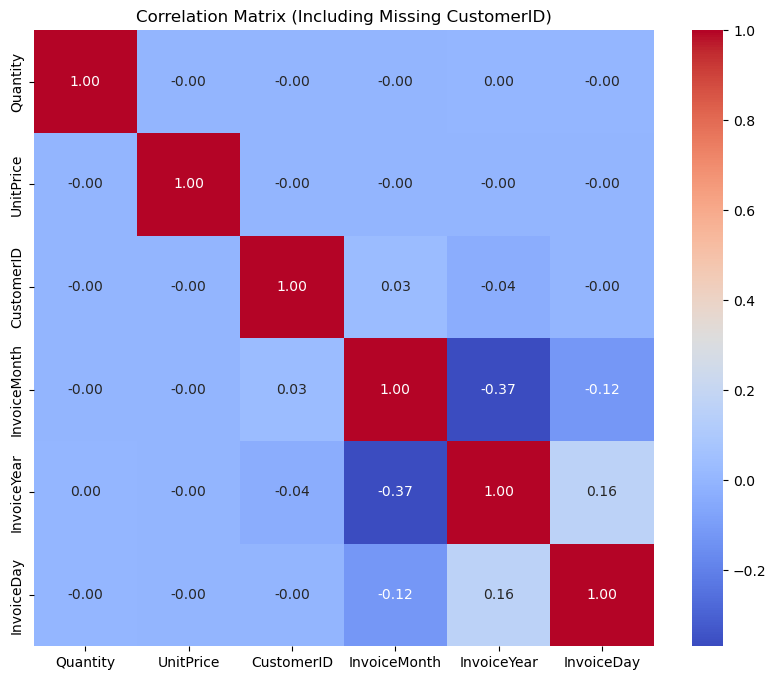

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Including Missing CustomerID)')
plt.show()

In [18]:
missing_desc_counts = df[df['CustomerID_missing'] == True]['Description'].value_counts().head(20)

print(missing_desc_counts)

Description
DOTCOM POSTAGE                        693
JUMBO BAG RED RETROSPOT               497
JUMBO STORAGE BAG SUKI                414
JUMBO SHOPPER VINTAGE RED PAISLEY     388
JUMBO BAG WOODLAND ANIMALS            372
JUMBO BAG PINK POLKADOT               348
RECYCLING BAG RETROSPOT               341
RED TOADSTOOL LED NIGHT LIGHT         328
SUKI  SHOULDER BAG                    326
GREEN REGENCY TEACUP AND SAUCER       324
PARTY BUNTING                         311
PACK OF 72 RETROSPOT CAKE CASES       305
WOODLAND CHARLOTTE BAG                304
RED RETROSPOT CHARLOTTE BAG           301
CHARLOTTE BAG SUKI DESIGN             300
WHITE HANGING HEART T-LIGHT HOLDER    299
REGENCY CAKESTAND 3 TIER              295
JAM MAKING SET PRINTED                294
RECIPE BOX PANTRY YELLOW DESIGN       290
JUMBO  BAG BAROQUE BLACK WHITE        287
Name: count, dtype: int64


In [19]:
not_missing_desc_counts = df[df['CustomerID_missing'] == False]['Description'].value_counts().head(20)

print(not_missing_desc_counts)

Description
WHITE HANGING HEART T-LIGHT HOLDER    2070
REGENCY CAKESTAND 3 TIER              1905
JUMBO BAG RED RETROSPOT               1662
ASSORTED COLOUR BIRD ORNAMENT         1418
PARTY BUNTING                         1416
LUNCH BAG RED RETROSPOT               1358
SET OF 3 CAKE TINS PANTRY DESIGN      1232
POSTAGE                               1196
LUNCH BAG  BLACK SKULL.               1126
PACK OF 72 RETROSPOT CAKE CASES       1080
SPOTTY BUNTING                        1029
PAPER CHAIN KIT 50'S CHRISTMAS        1029
LUNCH BAG SPACEBOY DESIGN             1021
LUNCH BAG CARS BLUE                   1012
NATURAL SLATE HEART CHALKBOARD         997
HEART OF WICKER SMALL                  996
LUNCH BAG PINK POLKADOT                977
JAM MAKING SET WITH JARS               974
REX CASH+CARRY JUMBO SHOPPER           955
LUNCH BAG SUKI DESIGN                  950
Name: count, dtype: int64


In [20]:
df_missing = df[df['CustomerID_missing'] == True]

desc_price_missing = df_missing.groupby('Description')['UnitPrice'].mean().sort_values(ascending=False)

print(desc_price_missing.head(20))  


Description
AMAZON FEE                             7324.784706
Manual                                  550.869533
Bank Charges                            293.625600
DOTCOM POSTAGE                          280.441126
HALL CABINET WITH 3 DRAWERS             100.000000
CINDERELLA CHANDELIER                    99.960000
Dotcomgiftshop Gift Voucher £100.00      83.330000
SET/4 WHITE RETRO STORAGE CUBES          59.006122
SILVER ROCCOCO CHANDELIER                58.290000
SAMPLES                                  50.404603
RUSTIC WOODEN CABINET, GLASS DOORS       49.960000
SWEETHEART CREAM STEEL TABLE RECT        46.620000
CHALKBOARD KITCHEN ORGANISER             45.806000
IVORY EMBROIDERED QUILT                  42.601667
CARRIAGE                                 42.222222
Dotcomgiftshop Gift Voucher £50.00       41.890000
MEDINA STAMPED METAL STOOL               41.645000
BOTANICAL GARDENS WALL CLOCK             41.640000
ROCOCO WALL MIRROR WHITE                 41.630000
SET 3 WICKER OVAL B

In [21]:
print(df['CustomerID'].nunique())


4372


Tough! With limited information as to the cause of N/A values for this dataset, there are some leading elements, but there are some key things here. It looks like missing data could be skewed in value as they correspond to administrative fees. They also seem to occur more frequently during the holidays, though it occurs throughout the year regardless. It seems that theyre also associated with luxury items, novelty items, distinct from non missing values. 

This is where is gets tricky, as it's hard to tell if the N/As are due to something beyond what is available in the dataset (i.e. manager omits ID's of certain customers, clerical errors, mis-scans, other factors, or not). As i'm in the early stages of this analysis, I'll keep my decision making to what is available in te data. I do note that there are some unique qualities to charges and items freuqneted during NA values, so, I might be able to group them based on those factors alone.

In [23]:
def classify_special_transaction(description):
    desc = str(description).lower()
    
    if 'fee' in desc or 'charge' in desc or 'postage' in desc or 'carriage' in desc or 'manual'in desc:
        return 'Administrative Fee'

    elif 'voucher' in desc:
        return 'Gift Voucher'
    
    elif 'cabinet' in desc or 'chandelier' in desc or 'stool' in desc or 'quilt' in desc or 'mirror' in desc:
        return 'Luxury Item'
    
    elif 'sample' in desc:
        return 'Sample Item'
    
    else:
        return 'Other Special'


In [24]:
df['Special_Customer_Flag'] = df['CustomerID'].isna()

df['CustomerID_filled'] = df['CustomerID'].fillna('SPECIAL_CUSTOMER')

In [34]:
df.loc[df['Special_Customer_Flag'] == True, 'SpecialTransactionType'] = df['Description'].apply(classify_special_transaction)

In [37]:
print(df[df['Special_Customer_Flag'] == True]['SpecialTransactionType'].value_counts())

SpecialTransactionType
Other Special         131167
Luxury Item             2090
Administrative Fee      1724
Sample Item               67
Gift Voucher              32
Name: count, dtype: int64


In [43]:
cost_summary = df[df['Special_Customer_Flag'] == True].groupby('SpecialTransactionType')['UnitPrice'].agg(['mean', 'median', 'sum', 'count']).sort_values(by='mean', ascending=False)

print(cost_summary)

                              mean  median        sum   count
SpecialTransactionType                                       
Administrative Fee      299.988324  16.740  517179.87    1724
Sample Item              47.395373  16.000    3175.49      67
Gift Voucher             23.254375  16.845     744.14      32
Luxury Item               6.535608   4.130   13659.42    2090
Other Special             4.240587   3.290  556225.09  131167


Ok, this is helpful. The N/A's seem to be mixed, with roughly 2000 rows accounting for half of the total price accumultaed from this group. It makes sense why there would be an N/A value to these, as they are not a direct product of consumer behavior, but likely automated fees. Things like vouchers and sample items also dont have customer ID's, and they could skew the analysis if included. Im going to move forward with removing these rows from the dataset, as they aren't indicative of consumer behavior (at least not in a proximal sense, signing up for things like amazon and fees could be a different analysis of behavior). It is unclear if Chen, Sain, and Guo (2012) had handled these values in their analysis, or if the dataset was updated after their analysis to include the customer ID column (it was never mentioned in their article). Though, for the sake of k-means they were handling numeric columns only, never inspecting or making use of the customer ID column. 

I will be approaching these values, which may result in different clusters from their article, but given the importance of the finding it seems useful to do so. 

In [48]:
print(df.head(10))

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   

          InvoiceDate  UnitPrice  CustomerID         Country  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   
2 2010-12-01 08

Before going back, and concluding the investigation into N/A values and causes, it was noted that 1454 values in the description column were missing. So, I want to check, quickly, to see if those values also fall within the N/A customer rows. 

In [51]:
both_missing = df[df['Description'].isna() & df['CustomerID'].isna()]

print("Rows with both Description and CustomerID missing:", len(both_missing))


Rows with both Description and CustomerID missing: 1454


Indeed they do! So, overall I am going to make some simple adjustments to the data to remove administrative charges and rows with missing descriptions from the analysis. They can be re-included, if needed, but it is unlikely that administrative charges are relevant to the analysis of direct shopping/ purchasing behavior. Further, as the description is missing for 1454 rows, it could very well mean those are also administrative charges (evaluating the price of these rows might help guide that conclusions if the value is relatively large, as is the case here with administrative charges, but for the sake of time we will move on for now. 

In [54]:
# Removing columns categorized with description N/A or special transation type 'administrative'
df = df[~((df['Description'].isna()) | (df['SpecialTransactionType'] == 'Administrative_fee'))]


In [56]:
print(df.isna().sum())

InvoiceNo                      0
StockCode                      0
Description                    0
Quantity                       0
InvoiceDate                    0
UnitPrice                      0
CustomerID                133626
Country                        0
CustomerID_missing             0
InvoiceMonth                   0
InvoiceYear                    0
InvoiceDay                     0
Special_Customer_Flag          0
CustomerID_filled              0
SpecialTransactionType    406829
dtype: int64


Great! Now we have a good stopping pont for N/A cleaning, which could be re-visted for a deeper dive into this issue. Special Transaction Type misses a great deal of the products sold, and the amount missing corresponds to missing customer ID's. We have in this data set a flag for the missing customer ID's that can be used to filter/ examine data where ID's are missing, potentially looking back into those descriptions for further details. Finally, we have a Customer ID filled column, which fills in the N'A customer ID's with a "Special Purchase" value. These columns won't play a role in the clustering analysis, though for the sake of analysis shouldn't be forgotten. 

Now, referring back to the Chen, Sain, and Guo (2012), there were some intentional preprocessing these researchers used. This was done to prepare the data for analysis within the frequency and monetary model (RFM). This is a relatively classic data mining model, the approach of which segments customer behavior into profitable insights. There is one extention, possible with this data - which is the RFMT (T for time), or looking at the time since the first purchase, for deeper insights. 

Here, I will evaluate the data both within the context of the RFM and RFMT models, the compare their insights. First, lets preprocess the data according to the methods use by Chen, Sain, and Guo (2012). The first step will be to select the relevant columns. 

In [59]:
df_filtered = df[['CustomerID', 'CustomerID_filled','InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice', 'InvoiceDate', 'Country', 'Special_Customer_Flag']]

The next step would be to create an aggregated variable 'Amount' to calculate UnitPrice by Quantity

In [62]:
df_filtered = df[['CustomerID','InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice', 'InvoiceDate', 'Country', 'Special_Customer_Flag']].copy()
df_filtered['Amount'] = df_filtered['UnitPrice'] * df_filtered['Quantity']

Next, seperating date and time

In [65]:
df_filtered['InvoiceDate'] = pd.to_datetime(df_filtered['InvoiceDate'])
df_filtered['Date'] = df_filtered['InvoiceDate'].dt.date
df_filtered['Time']=df_filtered['InvoiceDate'].dt.time

Filtering out rows where country not equal to UK

In [68]:
df_filtered = df_filtered[df_filtered['Country'] == 'United Kingdom']

Now, a bit of a snag here in terms of full replication of the Chen, Sain, and Guo (2012) article, as the dataset available does not have customer postal codes. In order to move forward, I have a few options. 1) I can reintroduce the country column, and sort by country 2) I can sort by customer ID 3) I skip sorting the data and move forward with creating the aggregates: Recency, Frequency, Monetary. 

By data gut is leaning towards a customer centric approach, as sorting by customer would also, to some degree, sort by postal code. It will miss nuances, like if two customers are from the same postal code vs not, but with a constrained dataset theres little alternatives. 

An analysis by country could be useful, though the distribution of the data is heavily skewed towards UK purchases (seen above). 

One final dilemma with the dataset is the special customer and luxury items, formerly the customer ID's with N/A. Given that there is no postal code to differentiate the items, and no further information to group/ identify customers, I'll move forward with excluding them from the analysis (to start), The flag filtering can always bring them back in. One final check:

In [71]:
lux= df[df['SpecialTransactionType'] == 'Luxury Item']

real_lux = lux[lux['Special_Customer_Flag'] == False]

print(len(real_lux))

0


In [73]:
df_real_customers = df_filtered[df_filtered['Special_Customer_Flag'] == False]
df_rfm = df_real_customers[['CustomerID', 'InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice', 'Date', 'Time', 'InvoiceDate', 'Amount']]
df_rfm = df_rfm[df_rfm['InvoiceDate'] >= pd.to_datetime('2011-01-01')]

This next part was a bit tricky, in terms of creating the aggregate variables comparable to the Chen, Sain, and Guo (2012) article. 

They had used: 

proc means data= YourLibraryName.
SortedOriginalDataset n sum min
max mean;
var Amount;
by Postcode;
output out= YourLibraryName.TagretDatasetMonetary
(drop=_type_ _freq_) n=n sum=sum min=min max=max
mean=mean;
run;

Essentially aggregating the amount column (sum) by postcode. This was the only available code the provided within the article, so I had to take a, educated guess in terms of defining recency/ first purchase. For frequency, I aggregate unique purchases (unique invoice numbers) as frequency to define repeated transactions of a customer (not the amount of items they purchase). For monetary, I aggregate the amount column into 'sum' byt customer ID. Recency was a bit of a gamble, assuming they were comparing their dataset to present year (2012). I set the refernece date to January 1, 2012, considering recency to be the first purchase closed to that date (i.e. recent transaction from customer subtracted by the reference date). So, if that purchased something, lets say, November, their recency value would be 2. First Purchase was this process in reverse. 

In [75]:
reference_date = pd.to_datetime("2012-01-01")
start_date = pd.to_datetime("2011-01-01")

df_rfm = df_rfm[df_rfm['Amount'] > 0]

rfm = df_rfm.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',                         # Frequency
    'Amount': 'sum',                                # Monetary
    'InvoiceDate': [
        lambda x: (reference_date.to_period('M') - x.max().to_period('M')).n,   
        lambda x: (x.min().to_period('M') - start_date.to_period('M')).n       
    ]
}).reset_index()

rfm.columns = ['CustomerID', 'Frequency', 'Monetary', 'Recency', 'First_Purchase']

In [77]:
print("Date range:", df_rfm['InvoiceDate'].min(), "to", df_rfm['InvoiceDate'].max())


Date range: 2011-01-04 10:00:00 to 2011-12-09 12:49:00


In [79]:
rfm[['Recency', 'Frequency', 'Monetary', 'First_Purchase']].agg(['min', 'median', 'max'])


,Recency,Frequency,Monetary,First_Purchase
min,1.0,1.0,3.75,0.0
median,3.0,2.0,637.50,3.0
max,12.0,174.0,231822.69,11.0


<Axes: xlabel='Recency', ylabel='Count'>

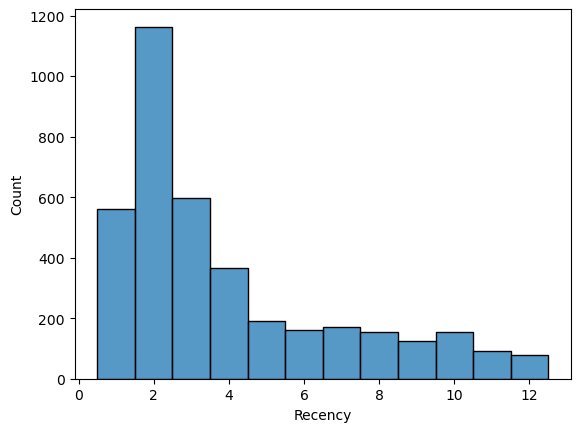

In [81]:
sns.histplot(data=rfm, x='Recency', discrete=True)


<Axes: xlabel='Frequency', ylabel='Count'>

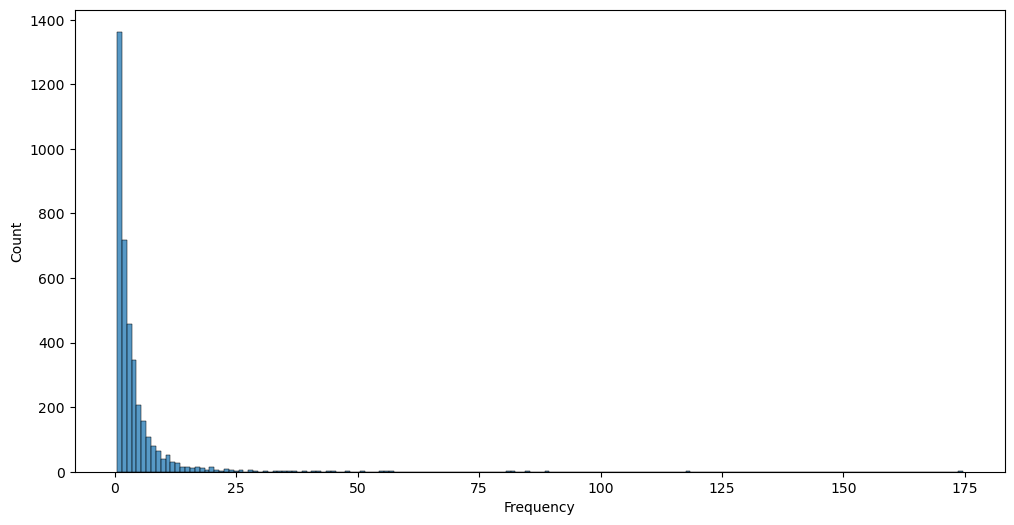

In [83]:
plt.figure(figsize=(12, 6))
sns.histplot(data=rfm, x='Frequency', discrete = True)

In [85]:
Q1 = rfm['Frequency'].quantile(0.01)
Q3 = rfm['Frequency'].quantile(0.99)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = rfm[rfm['Frequency'] > upper_bound]

In [87]:
clean_rfm = rfm[rfm['Frequency'] <= upper_bound]

<Axes: xlabel='Frequency', ylabel='Count'>

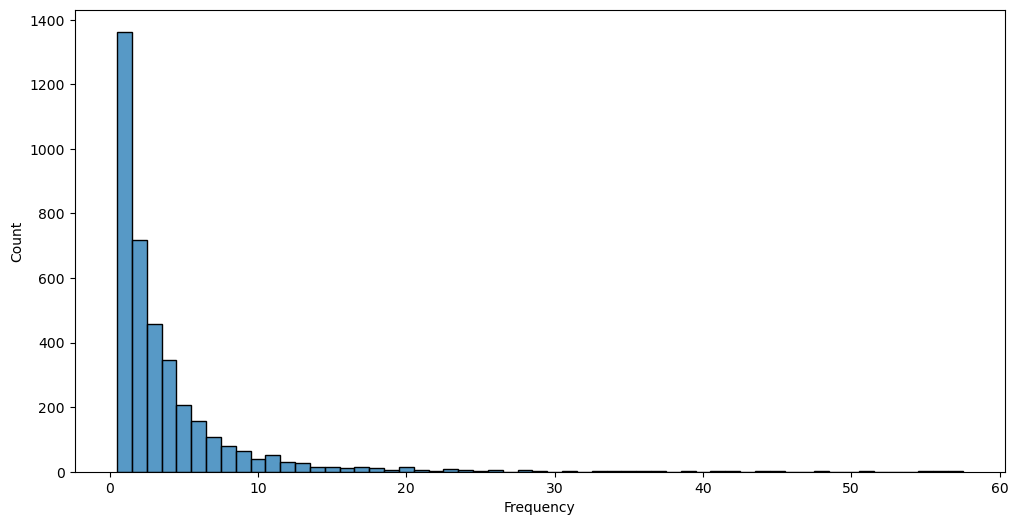

In [89]:
plt.figure(figsize=(12, 6))
sns.histplot(data=clean_rfm, x='Frequency', discrete = True)

<Axes: xlabel='Monetary', ylabel='Count'>

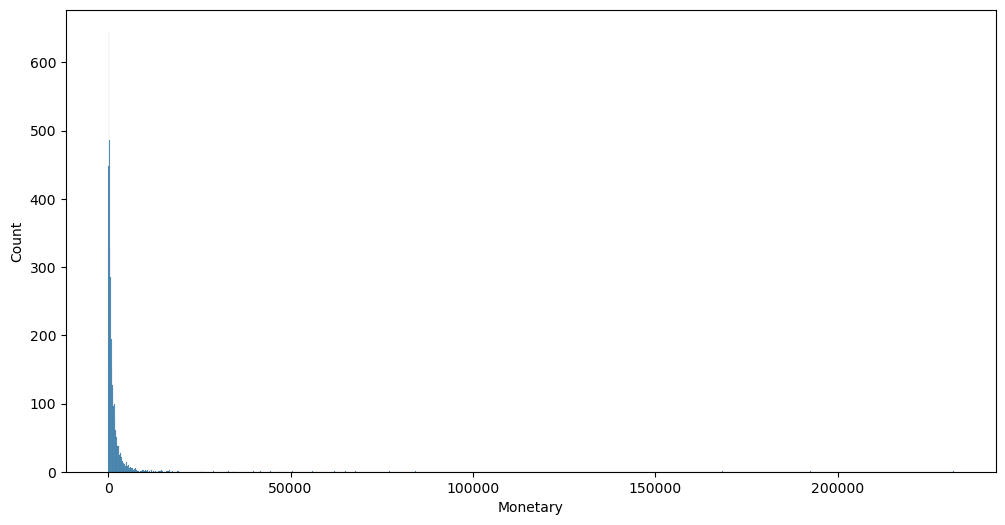

In [91]:
plt.figure(figsize=(12, 6))
sns.histplot(data=clean_rfm, x='Monetary')

In [92]:
Q1 = clean_rfm['Monetary'].quantile(0.01)
Q3 = clean_rfm['Monetary'].quantile(0.99)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mon_outliers = rfm[rfm['Monetary'] > upper_bound]
cln_rfm = clean_rfm[clean_rfm['Monetary'] <= upper_bound]

<Axes: xlabel='Monetary', ylabel='Count'>

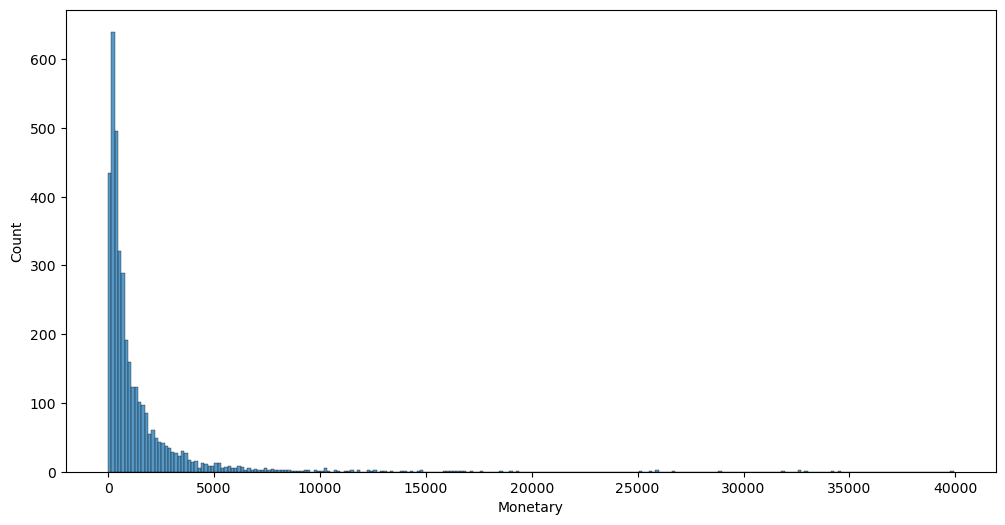

In [95]:
plt.figure(figsize=(12, 6))
sns.histplot(data=cln_rfm, x='Monetary')

In [97]:
rfm_scale_var = cln_rfm[['Recency', 'Frequency', 'Monetary']].copy()

Quick recap here: I've filtered the data to exlude the top 1% outliers from the data. This was in replication of the previous attempt (Chen, Sain & Guo, 2012). The data will be scaled to support it's use in k-means (sensitive to these factors). Then the elbow method will be used to determine the optimal number of clusters. 

In [102]:
scaler = StandardScaler()
rfm_scaled_array = scaler.fit_transform(rfm_scale_var)

# Create scaled DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled_array, columns=rfm_scale_var.columns, index=rfm_scale_var.index)

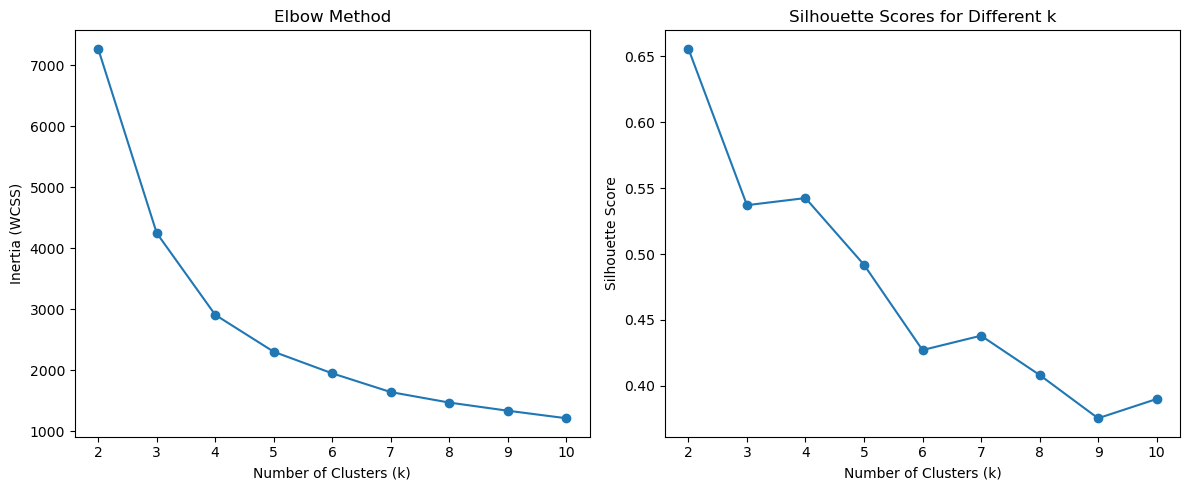

In [104]:
X = rfm_scaled
K_range = range(2, 11)

inertia_values = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X)

    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))

# Plot
plt.figure(figsize=(12, 5))

# Elbow plot
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia_values, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method")

# Silhouette plot
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k")

plt.tight_layout()
plt.show()


(Chen, Sain & Guo, 2012) had reported on 5 clusters in their analysis (postcode sorted). This approach identifies an optimal number of 3-4 (let's stick with 4). 

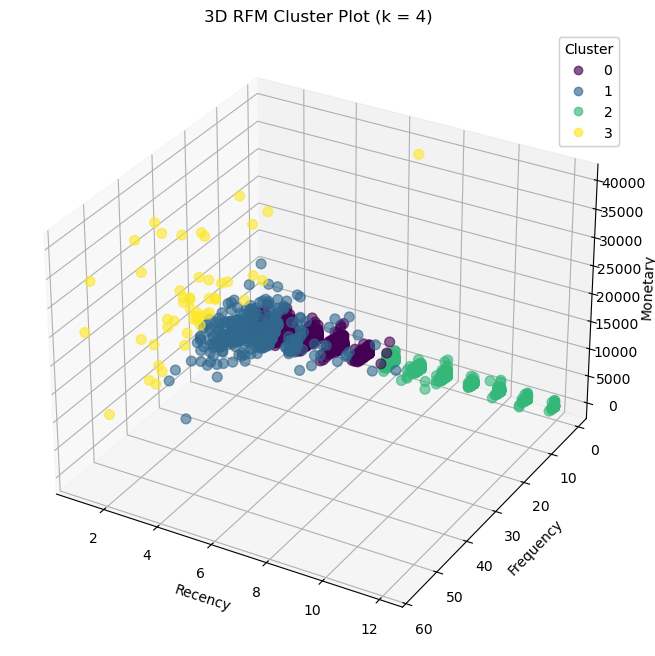

In [114]:
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=20)
cln_rfm = cln_rfm.copy()
cln_rfm['Cluster'] = kmeans.fit_predict(X)

# STEP 3: Plot clusters in 3D (using unscaled values)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    cln_rfm['Recency'],
    cln_rfm['Frequency'],
    cln_rfm['Monetary'],
    c=cln_rfm['Cluster'],
    cmap='viridis',
    s=50,
    alpha=0.6
)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title(f'3D RFM Cluster Plot (k = {k_optimal})')
ax.set_ylim(ax.get_ylim()[::-1])


legend = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend)

plt.show()